In [18]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from tqdm import tqdm

from aegear.model import EfficientUNet, TrajectoryPredictionNet
from aegear.datasets import FishHeatmapSequenceDataset

In [19]:
# Cell 2: Load EfficientUNet model (assume pretrained weights exist)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EfficientUNet()
model.load_state_dict(torch.load("../data/models/model_efficient_unet_2025-04-04.pth", map_location=device))
model.eval()
model.to(device);

print("Model loaded and moved to device:", device)

Model loaded and moved to device: cuda


In [20]:
import gdown

# 3. Download the data if not already in place
dataset_dir = '../data/training'
annotations_file = os.path.join(dataset_dir, 'tracking_E7_filtered.json')
video_dir = "../data/video"

os.makedirs(dataset_dir, exist_ok=True)

# Check if each of the dataset units is present
if not os.path.exists(annotations_file):
    print("Downloading dataset...")
    # Google Drive share link
    file_id = "1osZGb1Wc_iZ-mCAV54OhTwsmPN88nZ3y"
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, annotations_file, quiet=False)

if not os.path.exists(video_dir):
    print("Downloading video...")

    # Google Drive share link
    file_id = "1FJypI1WmZJj4iEo9nVfBvP8FjaoDf1Ob"
    url = f'https://drive.google.com/uc?id={file_id}'

    output = os.path.join(dataset_dir, "E7.MOV")
    gdown.download(url,output, quiet=False)

In [ ]:
dataset = FishHeatmapSequenceDataset(
    tracking_json_path=annotations_file,
    unet_model=model,
    video_dir="../data/video",
    device=device,
    history_lookback_s=1.0,
    n_history_samples=5,
    future_horizon_s=0.25,
    interpolation_smoothness=5.0,
    cache_path="../data/models/grutracker/training_cache",
)

val_fraction = 0.1
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Loaded cached sequence data from ../data/models/grutracker/training_cache
Train dataset size: 28584
Validation dataset size: 7146


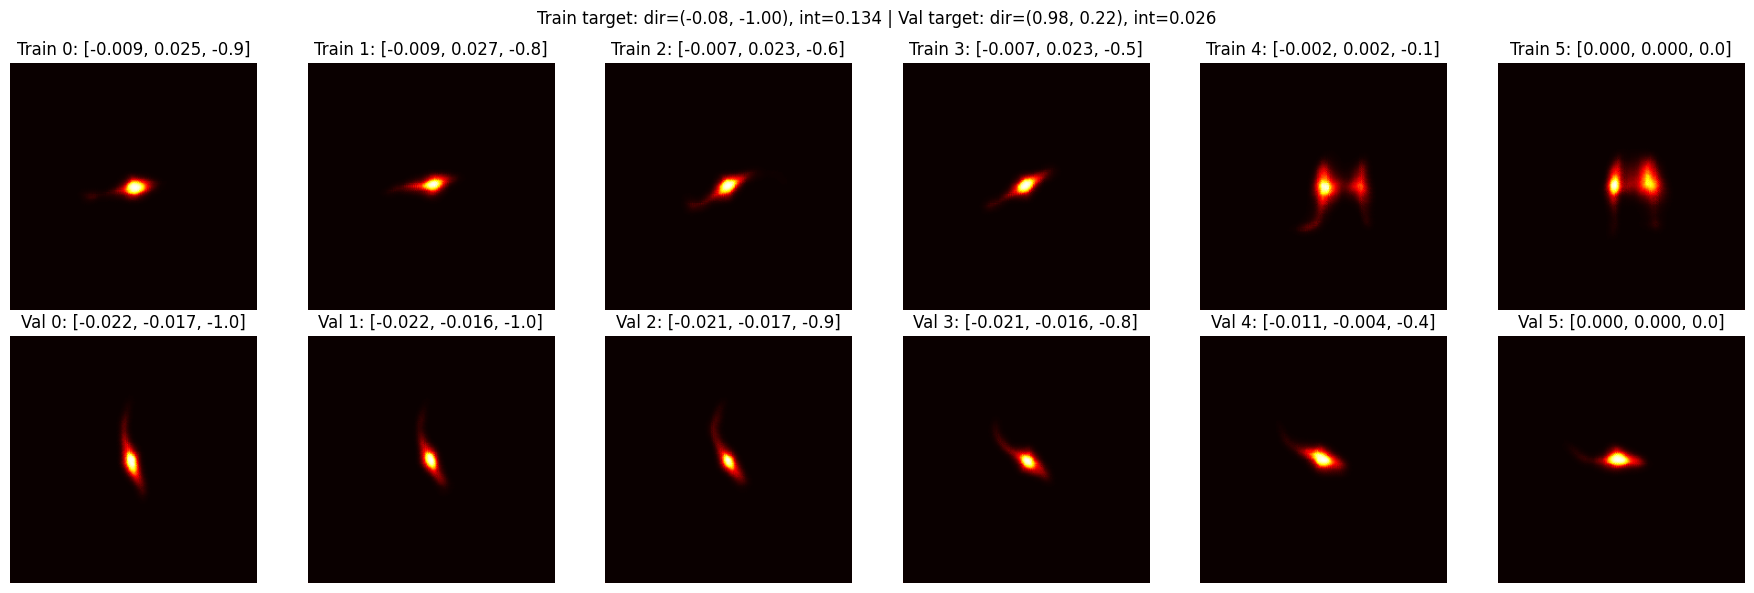

In [22]:
import random
import matplotlib.pyplot as plt

random_train_idx = random.randint(0, len(train_dataset) - 1)
random_val_idx = random.randint(0, len(val_dataset) - 1)

train_heatmaps, train_past, train_dt, train_target = train_dataset[random_train_idx]
val_heatmaps, val_past, val_dt, val_target = val_dataset[random_val_idx]

T = train_heatmaps.shape[0]
fig, axs = plt.subplots(2, T, figsize=(T * 3, 6))

for i in range(T):
    t_offset = train_past[i, :]
    t_dt = train_dt[i, :]
    v_offset = val_past[i, :]
    v_dt = val_dt[i, :]

    axs[0, i].imshow(train_heatmaps[i, 0], cmap='hot')
    axs[0, i].set_title(f"Train {i}: [{t_offset[0]:.3f}, {t_offset[1]:.3f}, {t_dt[0]:.1f}]")
    axs[0, i].axis('off')

    axs[1, i].imshow(val_heatmaps[i, 0], cmap='hot')
    axs[1, i].set_title(f"Val {i}: [{v_offset[0]:.3f}, {v_offset[1]:.3f}, {v_dt[0]:.1f}]")
    axs[1, i].axis('off')

plt.suptitle(
    f"Train target: dir=({train_target[0]:.2f}, {train_target[1]:.2f}), int={train_target[2]:.3f} | "
    f"Val target: dir=({val_target[0]:.2f}, {val_target[1]:.2f}), int={val_target[2]:.3f}"
)
plt.tight_layout()
plt.show()


In [23]:
# Cell 6: Instantiate model, loss, optimizer
tracker = TrajectoryPredictionNet().to(device)
optimizer = torch.optim.Adam(tracker.parameters(), lr=1e-3)

def compute_loss(preds, targets):
    """
    Compute the training loss for fish trajectory prediction.

    This loss function separately evaluates the predicted direction vector and
    movement intensity (scalar magnitude) of the fish's motion. Direction is
    treated as a 2D unit vector, and intensity as a scalar speed normalized 
    to the full-frame coordinate system.

    Args:
        preds (Tensor): Predicted output of shape (B, 3), where the first two
                        values are direction (dx, dy) and the third is intensity.
        targets (Tensor): Ground truth targets of shape (B, 3), same format as preds.

    Returns:
        total_loss (Tensor): Sum of direction and intensity MSE losses.
        direction_loss (Tensor): MSE loss on the direction vectors.
        intensity_loss (Tensor): MSE loss on the intensity scalars.
    """

    # preds, targets: [B, 3] → [dx, dy, intensity]
    pred_dir = preds[:, :2]
    target_dir = targets[:, :2]
    pred_intensity = preds[:, 2]
    target_intensity = targets[:, 2]

    direction_loss = torch.nn.functional.mse_loss(pred_dir, target_dir)
    intensity_loss = torch.nn.functional.mse_loss(pred_intensity, target_intensity)

    return direction_loss + intensity_loss, direction_loss, intensity_loss

In [ ]:
model_dir = '../data/models/grutracker'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

writer = SummaryWriter(log_dir=log_dir, flush_secs=1)
best_val_loss = float('inf')
losses = []

epochs = 200
epoch_save_interval = 10
epoch_bar = tqdm(range(epochs), desc="Epochs")

for epoch in epoch_bar:
    tracker.train()
    train_loss = 0.0
    train_dir_loss = 0.0
    train_int_loss = 0.0

    for heatmaps, relative_offsets, dt_seq, target in train_loader:
        heatmaps = heatmaps.to(device)
        relative_offsets = relative_offsets.to(device)
        dt_seq = dt_seq.to(device)
        target = target.to(device)

        preds = tracker(heatmaps, relative_offsets, dt_seq)
        loss, dir_loss, int_loss = compute_loss(preds, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dir_loss += dir_loss.item()
        train_int_loss += int_loss.item()

    tracker.eval()
    val_loss = 0.0

    with torch.no_grad():
        for heatmaps, relative_offsets, dt_seq, target in val_loader:
            heatmaps = heatmaps.to(device)
            relative_offsets = relative_offsets.to(device)
            dt_seq = dt_seq.to(device)
            target = target.to(device)

            preds = tracker(heatmaps, relative_offsets, dt_seq)
            loss, _, _ = compute_loss(preds, target)
            val_loss += loss.item()

    n_train = len(train_loader)
    train_loss /= n_train
    train_dir_loss /= n_train
    train_int_loss /= n_train
    val_loss /= len(val_loader)

    losses.append((train_loss, val_loss))

    writer.add_scalar('Loss/train_total', train_loss, epoch)
    writer.add_scalar('Loss/train_direction', train_dir_loss, epoch)
    writer.add_scalar('Loss/train_intensity', train_int_loss, epoch)
    writer.add_scalar('Loss/val_total', val_loss, epoch)

    epoch_bar.set_postfix(train_loss=train_loss, val_loss=val_loss, best_val_loss=best_val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(tracker.state_dict(), f'{model_dir}/best_model.pth')

    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(tracker.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()


Epochs: 100%|██████████| 100/100 [20:42<00:00, 12.42s/it, best_val_loss=0.0395, train_loss=0.0286, val_loss=0.0409]


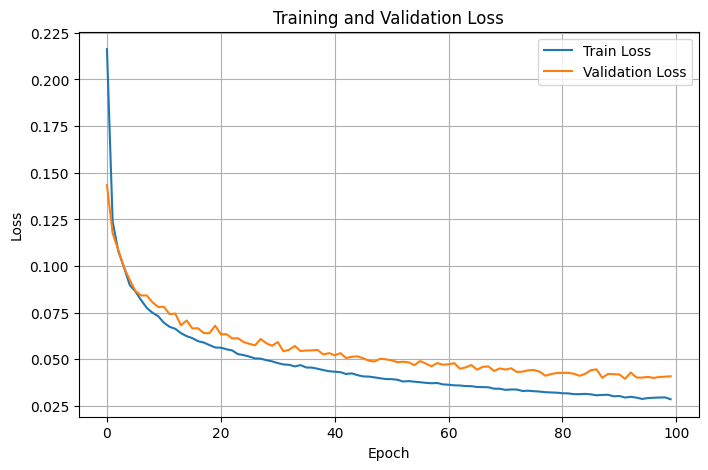

In [25]:
# 7. Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Load the best model for inference
tracker.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [27]:
def visualize_prediction_grid(dataset, model, rows=4, cols=8):
    model.eval()
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))

    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axs[r, c]

        # Get data from dataset
        heatmaps, rel_offsets, dt_seq, target = dataset[i]
        heatmaps = heatmaps.unsqueeze(0).to(device)        # [1, T, 1, H, W]
        rel_offsets = rel_offsets.unsqueeze(0).to(device)  # [1, T, 2]
        dt_seq = dt_seq.unsqueeze(0).to(device)            # [1, T, 1]
        target = target.cpu().numpy()                      # [3]

        # Prediction
        with torch.no_grad():
            pred = model(heatmaps, rel_offsets, dt_seq).squeeze(0).cpu().numpy()  # [3]

        pred_direction = pred[:2]
        target_direction = target[:2]

        # Visualize on center of frame
        h, w = heatmaps.shape[3:]
        center = np.array([w // 2, h // 2])

        pred_point = center + pred_direction * 40  # scaled for visibility
        target_point = center + target_direction * 40

        # Last heatmap frame
        frame = heatmaps[0, -1, 0].cpu().numpy()
        ax.imshow(frame, cmap='hot')
        ax.scatter(*target_point, c='green', marker='x', s=40, label='GT')
        ax.scatter(*pred_point, c='blue', marker='o', s=20, label='Pred')
        ax.axis('off')
        ax.set_title(f"#{i}", fontsize=8)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()


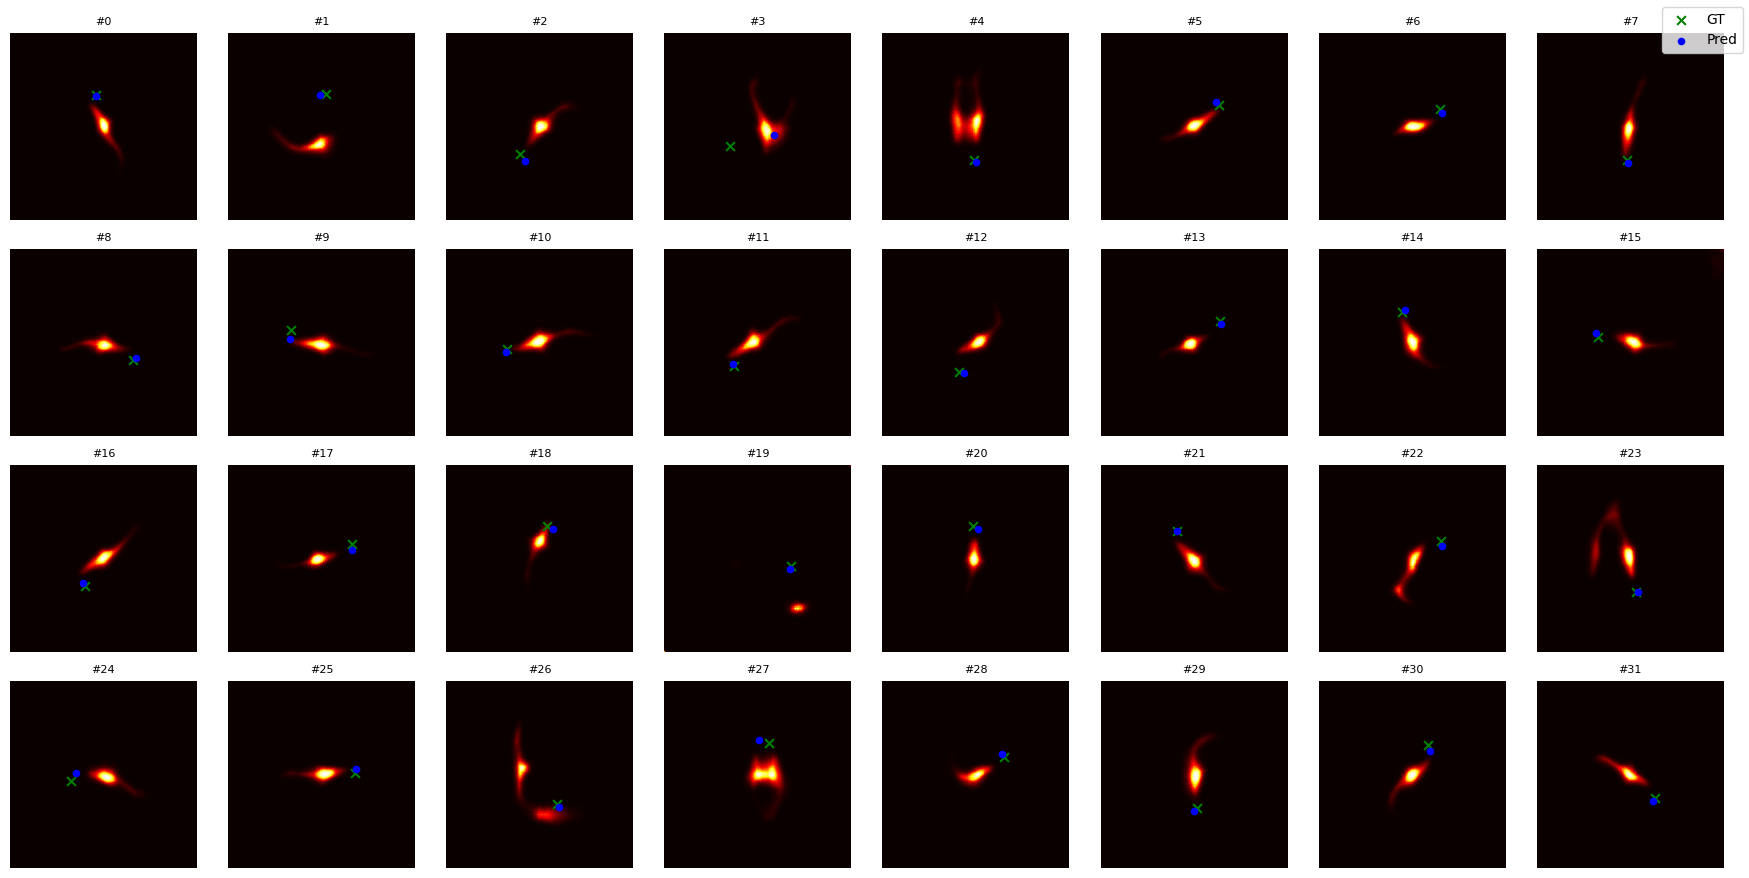

In [28]:
visualize_prediction_grid(val_dataset, tracker, rows=4, cols=8)

In [29]:
def evaluate_and_plot_extremes(dataset, model, metric="l2", device="cuda"):
    model.eval()
    errors = []

    for i in range(len(dataset)):
        heatmaps, rel_offsets, dt_seq, target = dataset[i]
        heatmaps = heatmaps.unsqueeze(0).to(device)
        rel_offsets = rel_offsets.unsqueeze(0).to(device)
        dt_seq = dt_seq.unsqueeze(0).to(device)
        target = target.cpu().numpy()  # [3]

        with torch.no_grad():
            pred = model(heatmaps, rel_offsets, dt_seq).squeeze(0).cpu().numpy()  # [3]

        if metric == "l2":
            error = np.linalg.norm(pred - target)
        else:
            error = ((pred - target) ** 2).mean()

        errors.append((error, i, pred, target))

    # Sort and extract cases
    errors.sort(key=lambda x: x[0])
    best = errors[:5]
    mid = errors[len(errors)//2 - 2:len(errors)//2 + 3]
    worst = errors[-5:]

    def _plot_group(name, group):
        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
        for j, (err, i, pred, target) in enumerate(group):
            heatmaps, _, _, _ = dataset[i]
            frame = heatmaps[-1, 0].cpu().numpy()

            h, w = heatmaps.shape[2:]
            center = np.array([w // 2, h // 2])
            pred_point = center + pred[:2] * 40
            target_point = center + target[:2] * 40

            ax = axs[j]
            ax.imshow(frame, cmap='hot')
            ax.scatter(*target_point, c='green', marker='x', s=20, label='GT')
            ax.scatter(*pred_point, c='blue', marker='o', s=20, label='Pred')
            ax.set_title(f"#{i}\nErr: {err:.2f}", fontsize=8)
            ax.axis('off')
        fig.suptitle(name, fontsize=14)
        plt.tight_layout()
        plt.show()

    _plot_group("Worst 5 Predictions", worst)
    _plot_group("Median 5 Predictions", mid)
    _plot_group("Best 5 Predictions", best)



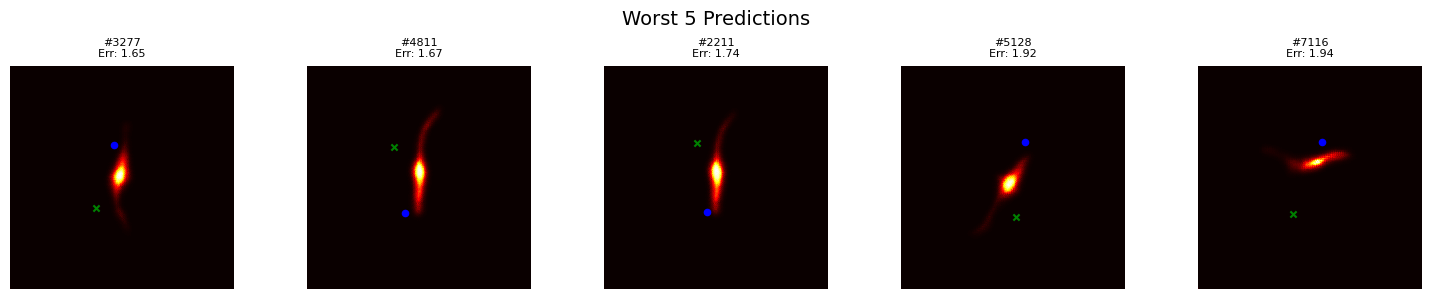

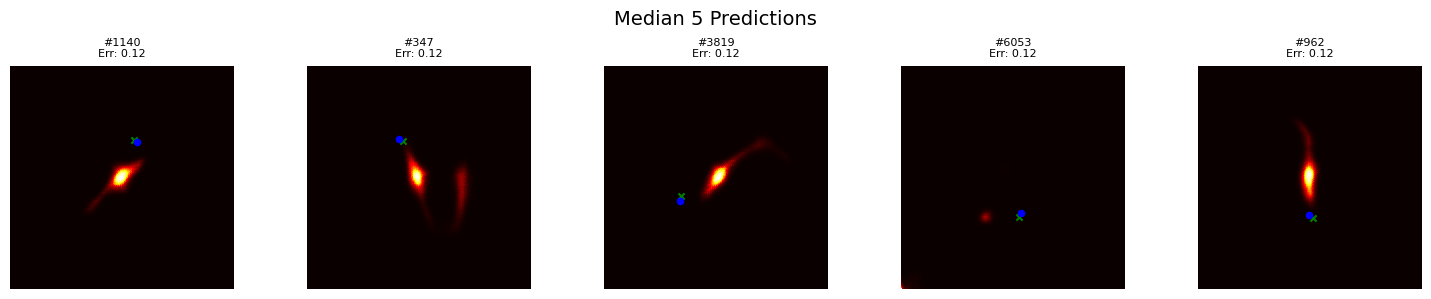

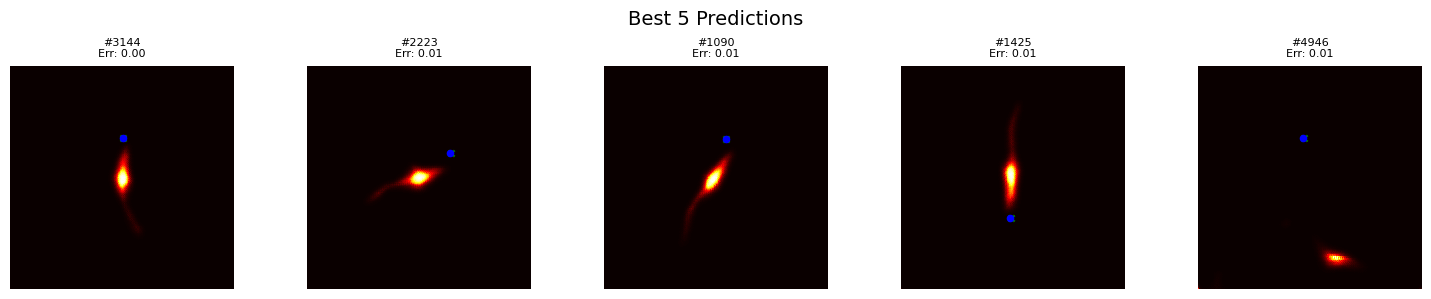

In [30]:
evaluate_and_plot_extremes(val_dataset, tracker)

In [31]:
def visualize_temporal_debug_grid(dataset, model, rows=3, cols=3, canvas_size=300):
    """
    Visualizes temporal prediction by overlaying heatmaps and trajectory on a canvas.
    """

    model.eval()
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    center = np.array([canvas_size // 2, canvas_size // 2])
    total_samples = rows * cols

    for i in range(total_samples):
        heatmaps, rel_offsets, dt_seq, target = dataset[i]
        T, _, H, W = heatmaps.shape

        # Prepare tensors for prediction
        heatmaps_in = heatmaps.unsqueeze(0).to(device)        # [1, T, 1, H, W]
        rel_offsets_in = rel_offsets.unsqueeze(0).to(device)  # [1, T, 2]
        dt_seq_in = dt_seq.unsqueeze(0).to(device)            # [1, T, 1]

        with torch.no_grad():
            pred = model(heatmaps_in, rel_offsets_in, dt_seq_in).squeeze(0).cpu().numpy()  # [3]

        direction_pred = pred[:2]
        direction_gt = target[:2].cpu().numpy()

        # Draw on canvas
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        positions = []

        for t in range(T):
            pos = center + rel_offsets[t].numpy() * canvas_size  # scale relative offset to canvas
            positions.append(pos)
            top = int(pos[1] - H // 2)
            left = int(pos[0] - W // 2)

            hm = heatmaps[t, 0].numpy()
            alpha = 0.15 + 0.25 * ((t + 1) / T)

            y1, y2 = max(0, top), min(canvas_size, top + H)
            x1, x2 = max(0, left), min(canvas_size, left + W)
            hm_y1, hm_y2 = y1 - top, y1 - top + (y2 - y1)
            hm_x1, hm_x2 = x1 - left, x1 - left + (x2 - x1)

            canvas[y1:y2, x1:x2] = (
                (1 - alpha) * canvas[y1:y2, x1:x2] + alpha * hm[hm_y1:hm_y2, hm_x1:hm_x2]
            )

        pred_abs = center + direction_pred * canvas_size * 0.1
        target_abs = center + direction_gt * canvas_size * 0.1

        ax = axs.flatten()[i]
        ax.imshow(canvas, cmap="hot", origin="upper")

        marker_cmap = plt.get_cmap("jet")
        for t, pos in enumerate(positions):
            color = marker_cmap(t / (T - 1))
            ax.plot(pos[0], pos[1], marker="o", color=color, markersize=6)

        traj = np.array(positions)
        ax.plot(traj[:, 0], traj[:, 1], linestyle="-", color="cyan", linewidth=1)
        ax.plot([center[0], pred_abs[0]], [center[1], pred_abs[1]], "--", color="blue", linewidth=1)
        ax.plot([center[0], target_abs[0]], [center[1], target_abs[1]], "--", color="green", linewidth=1)
        ax.plot(pred_abs[0], pred_abs[1], "o", color="blue", markersize=8, label="Pred")
        ax.plot(target_abs[0], target_abs[1], "x", color="green", markersize=8, label="GT")

        ax.set_title(f"Sample #{i}", fontsize=10)
        ax.axis("off")

    handles = [
        plt.Line2D([0], [0], marker="o", color="blue", linestyle="--", label="Pred"),
        plt.Line2D([0], [0], marker="x", color="green", linestyle="--", label="GT")
    ]
    fig.legend(handles=handles, loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.show()


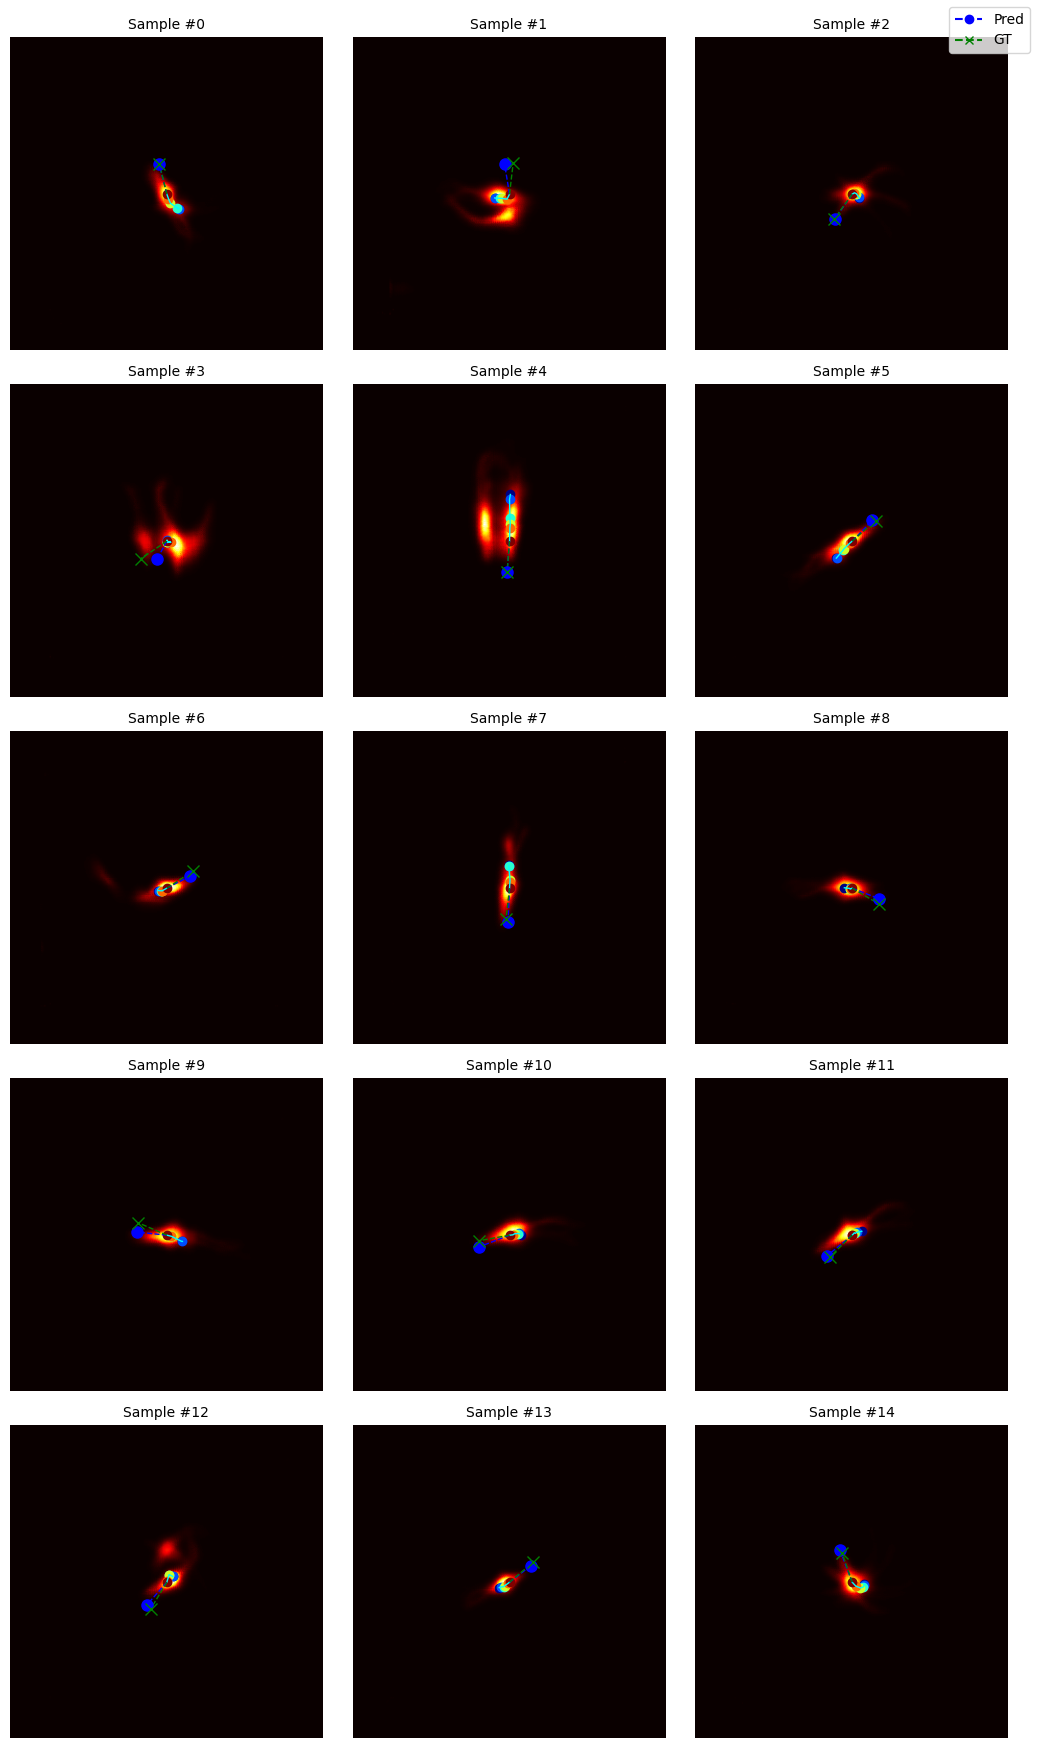

In [32]:
visualize_temporal_debug_grid(val_dataset, tracker, rows=5, cols=3, canvas_size=300)


In [33]:
def evaluate_metrics(dataset, model):
    model.eval()
    angle_errors = []
    intensity_errors = []
    relative_intensity_errors = []

    for i in range(len(dataset)):
        heatmaps, rel_offsets, dt_seq, target = dataset[i]
        heatmaps = heatmaps.unsqueeze(0).to(device)
        rel_offsets = rel_offsets.unsqueeze(0).to(device)
        dt_seq = dt_seq.unsqueeze(0).to(device)
        target = target.cpu().numpy()  # [3]

        with torch.no_grad():
            pred = model(heatmaps, rel_offsets, dt_seq).squeeze(0).cpu().numpy()

        pred_dir = pred[:2] / (np.linalg.norm(pred[:2]) + 1e-6)
        target_dir = target[:2] / (np.linalg.norm(target[:2]) + 1e-6)

        cos_sim = np.clip(np.dot(pred_dir, target_dir), -1.0, 1.0)
        angle_deg = np.degrees(np.arccos(cos_sim))

        pred_int = pred[2]
        target_int = target[2]

        intensity_err = abs(pred_int - target_int)
        rel_intensity_err = abs(pred_int - target_int) / (target_int + 1e-6)

        angle_errors.append(angle_deg)
        intensity_errors.append(intensity_err)
        relative_intensity_errors.append(rel_intensity_err)

    def stats(arr):
        arr = np.array(arr)
        return {
            "mean": np.mean(arr),
            "median": np.median(arr),
            "max": np.max(arr),
            "std": np.std(arr)
        }

    print("Angular Error (degrees):", stats(angle_errors))
    print("Intensity Error:", stats(intensity_errors))
    print("Relative Intensity Error:", stats(relative_intensity_errors))


In [34]:
evaluate_metrics(val_dataset, tracker)

Angular Error (degrees): {'mean': np.float32(9.70996), 'median': np.float32(5.286463), 'max': np.float32(178.55447), 'std': np.float32(16.58573)}
Intensity Error: {'mean': np.float32(0.019455502), 'median': np.float32(0.015286823), 'max': np.float32(0.15902176), 'std': np.float32(0.016979922)}
Relative Intensity Error: {'mean': np.float32(19.63988), 'median': np.float32(0.31929708), 'max': np.float32(45194.504), 'std': np.float32(690.43384)}
